# Libraries

In [1]:
import numpy as np
# from numpy import genfromtxt
import matplotlib.pyplot as plt

# Keras for TensorFlow
from tensorflow.contrib.keras.python.keras.models import Sequential
from tensorflow.contrib.keras.python.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout
from tensorflow.contrib.keras.python.keras.optimizers import Adam, RMSprop
from tensorflow.contrib.keras.python.keras.callbacks import EarlyStopping
from tensorflow.contrib.keras.python.keras.regularizers import l1, l2

import cv2
# from tensorflow.contrib.keras.python.keras.applications.resnet50 import ResNet50

# Load training and validation sets

In [2]:
trainingset_x = np.loadtxt('gender/wiki_crop/64_64_50614_4098_training_x_onehot.csv', delimiter=',')
trainingset_y = np.loadtxt('gender/wiki_crop/64_64_50614_4098_training_y_onehot.csv', delimiter=',')

testingset_x = np.loadtxt('gender/wiki_crop/64_64_11938_4098_testing_x_onehot.csv', delimiter=',')
testingset_y = np.loadtxt('gender/wiki_crop/64_64_11938_4098_testing_y_onehot.csv', delimiter=',')

valset_x = np.loadtxt('gender/wiki_crop/64_64_5968_4098_val_x_onehot.csv', delimiter=',')
valset_y = np.loadtxt('gender/wiki_crop/64_64_5968_4098_val_y_onehot.csv', delimiter=',')

In [3]:
trainingset_x.shape

(50614, 4096)

In [4]:
trainingset_y.shape

(50614, 2)

In [5]:
valset_x.shape

(5968, 4096)

In [6]:
valset_y.shape

(5968, 2)

# Data processing

In [7]:
img_dim = 64
n_channels = 1
n_inputs = img_dim*img_dim
n_classes = 2

trainingset_x = trainingset_x.reshape(trainingset_x.shape[0], img_dim, img_dim)
trainingset_x = np.expand_dims(trainingset_x, axis=4)

testingset_x = testingset_x.reshape(testingset_x.shape[0], img_dim, img_dim)
testingset_x = np.expand_dims(testingset_x, axis=4)

valset_x = valset_x.reshape(valset_x.shape[0], img_dim, img_dim)
valset_x = np.expand_dims(valset_x, axis=4)

# Some useful functions

#### Get label from vector or number

In [8]:
def get_label(ohv):
    if ohv.shape[0] == 1:
        indx = ohv[0]
    else:
        indx = np.argmax(ohv)
        
    if indx == 0:
        return 'female'
    elif indx == 1:
        return 'male'

In [174]:
def predict_gender_from_image_file(file_name):
    img = cv2.imread(file_name)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    # plt.imshow(img, cmap='gray')
    plt.show()

    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = cv2.resize(img, (64, 64))

    img = cv2.transpose(img)
    img = img.reshape([1, img_dim, img_dim, 1])
    pred_cls = model.predict_classes(img, verbose=0)
    proba = model.predict(img, verbose=0)

    print('> predicted gender: %s (%f%%)'
          % (get_label(pred_cls), np.max(proba)))

#### Plot samples

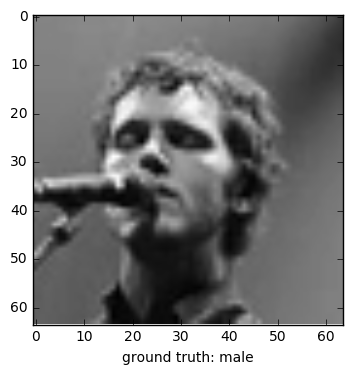

In [164]:
indx = 4000
img = trainingset_x[indx, :]
img = img.reshape([img_dim, img_dim])
img = np.transpose(img)
plt.imshow(img, cmap='gray')
plt.xlabel('ground truth: ' + get_label(trainingset_y[indx]))
plt.show()

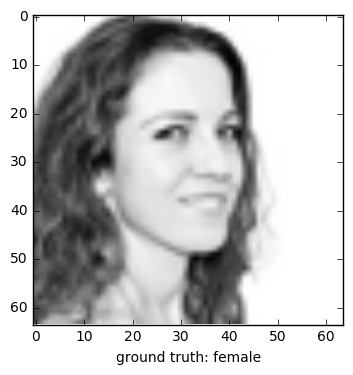

In [171]:
indx = 5200
img = valset_x[indx, :]
# img = img.reshape([img_dim, img_dim])
img = img.reshape([img_dim, img_dim])
img = np.transpose(img)
# plt.imshow(img)
plt.imshow(img, cmap='gray')
plt.xlabel('ground truth: ' + get_label(valset_y[indx]))
plt.show()

# Define CNN model using Keras + TensorFlow

#### A model in Keras + TensorFlow defined as a sequence of layers

In [97]:
model = Sequential()

#### Convolutional layers and max pooling layers

In [98]:
model.add(Conv2D(64, (3, 3), activation='relu', padding='same',
                 input_shape=(img_dim, img_dim, n_channels)))

In [99]:
model.add(Conv2D(64, (3, 3), activation='relu'))

In [100]:
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

In [101]:
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))

In [102]:
model.add(Conv2D(128, (3, 3), activation='relu'))

In [103]:
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

In [104]:
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))

In [105]:
model.add(Conv2D(128, (3, 3), activation='relu'))

In [106]:
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#### Fully connected layer

In [107]:
n_hidden_units = 2048

model.add(Flatten())
# model.add(Dense(n_hidden_units, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(n_hidden_units, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_hidden_units, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

# Compile the model

In [108]:
opt = Adam(lr=0.0001, decay=10e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Training the model

In [109]:
batch_size = 256
n_epoches = 500

# Stop training when the validation loss does not change significantly in 20 epoches
early_stopping = EarlyStopping(monitor='val_loss', patience=50)

model.fit(trainingset_x, trainingset_y,
          batch_size=batch_size, epochs=n_epoches,
          validation_data=(valset_x, valset_y),
          shuffle=True, callbacks=[early_stopping])

Train on 50614 samples, validate on 5968 samples
Epoch 1/500
50614/50614 [==============================] - 43s - loss: 1.1191 - acc: 0.6507 - val_loss: 0.5754 - val_acc: 0.7252
Epoch 2/500
50614/50614 [==============================] - 42s - loss: 0.5692 - acc: 0.7140 - val_loss: 0.4998 - val_acc: 0.8036
Epoch 3/500
50614/50614 [==============================] - 42s - loss: 0.5273 - acc: 0.7472 - val_loss: 0.4345 - val_acc: 0.8301
Epoch 4/500
50614/50614 [==============================] - 42s - loss: 0.4905 - acc: 0.7733 - val_loss: 0.4259 - val_acc: 0.8304
Epoch 5/500
50614/50614 [==============================] - 42s - loss: 0.4433 - acc: 0.8032 - val_loss: 0.3454 - val_acc: 0.8770
Epoch 6/500
50614/50614 [==============================] - 42s - loss: 0.4090 - acc: 0.8241 - val_loss: 0.3380 - val_acc: 0.8782
Epoch 7/500
50614/50614 [==============================] - 42s - loss: 0.3860 - acc: 0.8359 - val_loss: 0.3351 - val_acc: 0.8772
Epoch 8/500
50614/50614 [=======================

50614/50614 [==============================] - 42s - loss: 0.0753 - acc: 0.9732 - val_loss: 0.4044 - val_acc: 0.9068
Epoch 64/500
50614/50614 [==============================] - 42s - loss: 0.0751 - acc: 0.9736 - val_loss: 0.3979 - val_acc: 0.9048
Epoch 65/500
50614/50614 [==============================] - 42s - loss: 0.0764 - acc: 0.9729 - val_loss: 0.3974 - val_acc: 0.9112
Epoch 66/500
50614/50614 [==============================] - 42s - loss: 0.0708 - acc: 0.9754 - val_loss: 0.4488 - val_acc: 0.9042
Epoch 67/500
50614/50614 [==============================] - 42s - loss: 0.0738 - acc: 0.9741 - val_loss: 0.3971 - val_acc: 0.9097
Epoch 68/500
50614/50614 [==============================] - 42s - loss: 0.0733 - acc: 0.9745 - val_loss: 0.4213 - val_acc: 0.9068
Epoch 69/500
50614/50614 [==============================] - 42s - loss: 0.0719 - acc: 0.9749 - val_loss: 0.4391 - val_acc: 0.9124
Epoch 70/500
50614/50614 [==============================] - 42s - loss: 0.0707 - acc: 0.9753 - val_loss

# Evaluating trained model

In [172]:
scores = model.evaluate(testingset_x[0:9413 + 1, :], testingset_y[0:9413 + 1, :])
print('%s for male: %f' % (model.metrics_names[1], scores[1]))

scores = model.evaluate(testingset_x[9413:, :], testingset_y[9413:, :])
print('%s for female: %f' % (model.metrics_names[1], scores[1]))

2464/2525 [============================>.] - ETA: 0sacc for female: 0.739406


# Save trained model

In [111]:
model.save_weights('gender_hflip_female.h5')
print('> model saved')

> model saved


# Test trained model with a random testing sample

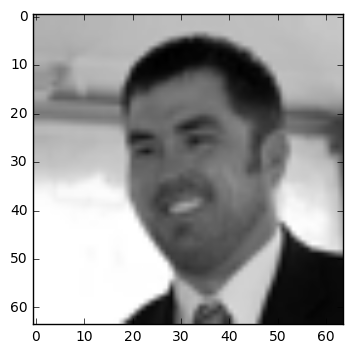

> testing image index: 1025
> true gender: male
> predicted gender: male


In [146]:
img_indx = np.uint32(np.random.rand()*(testingset_x.shape[0] - 1))
sample = testingset_x[img_indx, :]
sample = sample.reshape([1, img_dim, img_dim, 1])

pred_cls = model.predict_classes(sample, verbose=0)

sample = sample.reshape([img_dim, img_dim])
sample = np.transpose(sample)

plt.imshow(sample, cmap='gray')
plt.show()

print('> testing image index: %d\n> true gender: %s\n> predicted gender: %s'
      % (img_indx, get_label(testingset_y[img_indx, :]), get_label(pred_cls)))

# Test the trained model with personal images

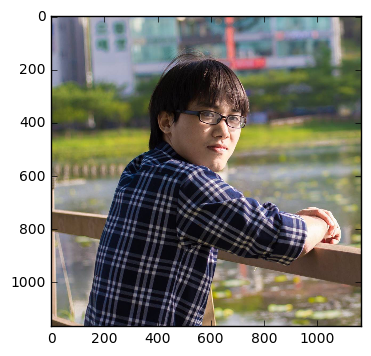

> predicted gender: male (0.998891%)


In [176]:
file_name = 'duong.jpg'
predict_gender_from_image_file(file_name)

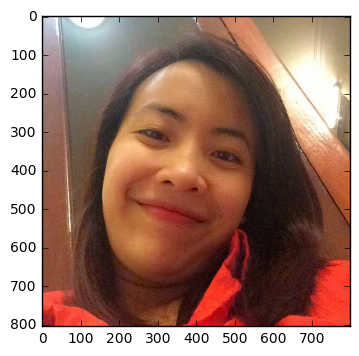

> predicted gender: female (0.994699%)


In [180]:
file_name = 'minh.jpg'
predict_gender_from_image_file(file_name)

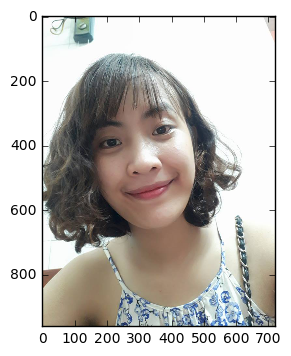

> predicted gender: female (0.998143%)


In [181]:
file_name = 'minh2.jpg'
predict_gender_from_image_file(file_name)

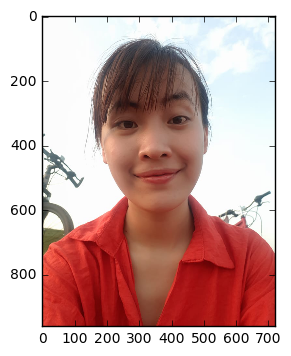

> predicted gender: female (0.868094%)


In [182]:
file_name = 'minh3.jpg'
predict_gender_from_image_file(file_name)

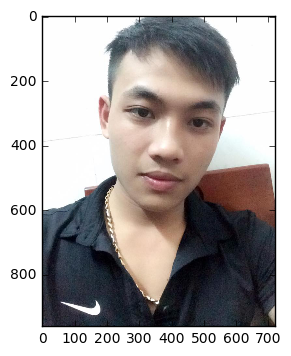

> predicted gender: male (0.999869%)


In [185]:
file_name = 'hau.jpg'
predict_gender_from_image_file(file_name)

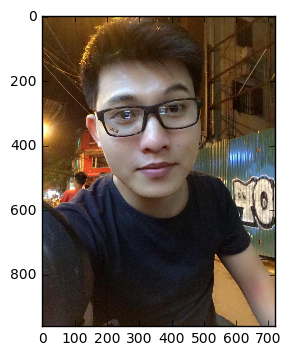

> predicted gender: male (0.823448%)


In [183]:
file_name = 'nghi2.jpg'
predict_gender_from_image_file(file_name)

## Other test cases

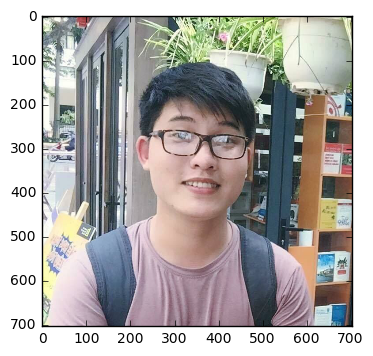

> predicted gender: female (0.769045%)


In [184]:
file_name = 'nghi.jpg'
predict_gender_from_image_file(file_name)

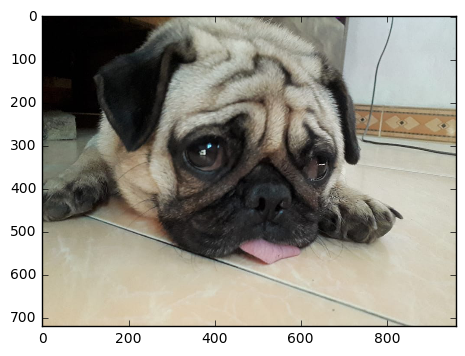

> predicted gender: male (0.703392%)


In [189]:
file_name = 'bun.jpg'
predict_gender_from_image_file(file_name)

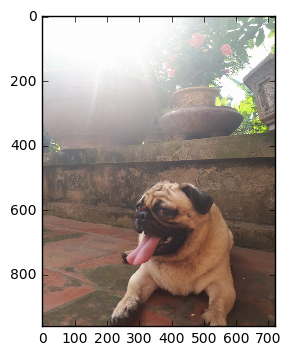

> predicted gender: male (0.999039%)


In [188]:
file_name = 'bun2.jpg'
predict_gender_from_image_file(file_name)